# **Bank Marketing Campaign - Term Deposit Prediction**
A Purwadhika Final Capstone Project

Author: Team Alpha

Date: February 2026

# 0. Importing Libraries

## 0.1 Basic Library

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 0.2 Statistical Library

In [78]:
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu

## 0.3 Machine Learning Libraries

In [79]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## 0.4 Imblearn

In [80]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

## 0.5 Sklearn Metrics

In [81]:
from sklearn.metrics import (classification_report, confusion_matrix, 
                            accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve, 
                            precision_recall_curve, auc, make_scorer, fbeta_score)

## 0.6 Model Interpretation

In [82]:
import shap

## 0.7 Model Saving

In [83]:
import joblib

# 1. Dataset Loading

In [84]:
df = pd.read_csv('raw_data.csv', sep=';', na_values='unknown')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# 2. The Introduction

**Bank Marketing Campaign**

## 2.1. Context

This project analyzes a Portuguese bank's marketing campaign data. The campaigns were conducted primarily through direct phone calls, offering clients the opportunity to place a term deposit. The dataset contains information about:
- Bank client demographics and financial status
- Campaign contact details
- Previous campaign outcomes
- Social and economic context indicators

The goal is to predict whether a client will subscribe to a term deposit based on these features.

## 2.2. Business Problem

Banks invest significant resources in marketing campaigns for term deposits. However, 
not all clients are equally likely to subscribe. The current approach may result in:

1. Wasted resources on clients unlikely to subscribe
2. Inefficient allocation of call center time
3. Potential customer fatigue from excessive contact attempts
4. Suboptimal ROI on marketing campaigns

`Key Questions`:
- Which clients are most likely to subscribe to term deposits?
- What factors most influence a client's decision?
- How can we optimize our targeting strategy?

## 2.3 Project Goals
`Primary Goal`:
Build a predictive model to identify clients most likely to subscribe to term deposits, 
enabling the bank to:
- Optimize marketing campaign efficiency
- Reduce operational costs
- Improve customer experience by reducing unnecessary contacts
- Increase overall campaign success rate

`Success Metrics`
- Maximize Recall (minimize missed potential subscribers)
- Maintain acceptable Precision (avoid too many false positives)
- Optimize F2-Score (prioritizing recall over precision)
- Achieve strong PR-AUC score for imbalanced data

## 2.4 Analytical Approach

This is a **Supervised Classification Problem** problem:
- Target Variable: Has the client subscribed? (yes/no)
- Approach: Classification algorithms
- Challenge: Class imbalance (fewer subscriptions than non-subscriptions)

Methodology:
1. Exploratory Data Analysis (EDA) with inferential statistics
2. Feature Engineering and preprocessing pipelines
3. Model benchmarking across multiple algorithms
4. Address class imbalance using resampling techniques
5. Hyperparameter tuning for best models
6. Model evaluation using business-relevant metrics
7. Model interpretation for actionable insights

## 2.5 Stakeholders

`Primary`:

1. Marketing Team: Use predictions to prioritize client contacts
2. Call Center Operations: Optimize resource allocation
3. Bank Management: Strategic decision-making on campaign investments

`Secondary`:

4. Data Science Team: Model development and maintenance
5. Compliance: Ensure ethical AI practices
6. Customers: Improved experience through targeted communication

## 2.6 Metrics Selection

Given our business context, we prioritize:

Primary Metrics: RECALL (Sensitivity)
- Why? Missing a potential subscriber (False Negative) costs more than 
  contacting a non-subscriber (False Positive)
- Each missed subscriber means lost revenue from term deposit interest

Secondary Metrics: F2-SCORE
- Weighted harmonic mean favoring Recall over Precision
- Balances the need to catch subscribers while maintaining some precision

Validation Metrics: PR-AUC (Precision-Recall Area Under Curve)
- Better than ROC-AUC for imbalanced datasets
- Focuses on the minority class (subscribers)

Cost Benefit Analysis:
- Cost of contact: Low (phone call cost)
- Cost of missed subscriber: High (lost deposit revenue)
- Therefore, we accept higher False Positive rate to minimize False Negatives

# 3. Comprehensive Explanatory Data Analysis

## 3.1. Dataset info and Data Dictionary

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [86]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [87]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,40858,41108,39457,32591,40198,40198,41188,41188,41188,41188,41188
unique,11,3,7,2,2,2,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


### 3.1.1. **Columns description**

`Personal data`

0. Age (numeric)
1. Job: type of job (cat)
2. Marital: marital status (cat)
3. education (cat)
4. Default: has credit in default? (cat)
5. Housing: has housing loan (cat)
6. Loan: has personal loan (cat)

`Related to last contact of current complain`

7. contact: contact communication type
8. month: last contact month of year
9. day of week: last contact day of week
10. duration: last contact duration

`Other attributes`

11. campaign: number of contacts performed during this campaign and for this client 
12. pdays: number of days that passed by after the client was last contacted from a previous campaign (999 = not contacted)
13. previous: number of contacts performed before this campaign and for this client (numeric)
14. poutcome: outcome of the previous marketing campaign

`Social-Economic Context`

15. emp.var.rate: employment variation rate - quarterly indicator (numeric)
16. cons.price.idx: consumer price index - monthly indicator (numeric)
17. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
18. euribor3m: euribor 3 month rate - daily indicator (numeric)
19. nr.employed: number of employees - quarterly indicator (numeric)

`Target Variable`

20. y - has the client subscribed a term deposit?

**Tidy up naming**

In [88]:
df['job'] = df['job'].replace({'admin.': 'admin'})
df['education'] = df['education'].replace({'university.degree': 'university degree'})
df['education'] = df['education'].replace({'professional.course': 'professional course'})
df['education'] = df['education'].replace({'high.school': 'high school'})
df['education'] = df['education'].replace({'basic.9y': 'basic 9 years'})
df['education'] = df['education'].replace({'basic.4y': 'basic 4 years'})
df['education'] = df['education'].replace({'basic.6y': 'basic 6 years'})

### 3.1.2 **Strategy for missing value and duplications handling:**
1. job: Impute with mode (most common job type)
2. marital: Impute with mode (most common marital status)
3. education: Impute with mode (most common education level)
4. default: DROP COLUMN (only 3 'yes' vs 40000+ 'no' - not informative)
5. housing: DROP ROWS with missing values (dropna)
6. loan: DROP ROWS with missing values (dropna)
7. Drop Duplicates

In [89]:
df.duplicated().sum()/len(df)*100

np.float64(0.02913469942701758)

Missing value percentage

In [90]:
df.isna().sum()/len(df)*100

age                0.000000
job                0.801204
marital            0.194231
education          4.202680
default           20.872584
housing            2.403613
loan               2.403613
contact            0.000000
month              0.000000
day_of_week        0.000000
duration           0.000000
campaign           0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
y                  0.000000
dtype: float64

### 3.1.3 **Outlier**

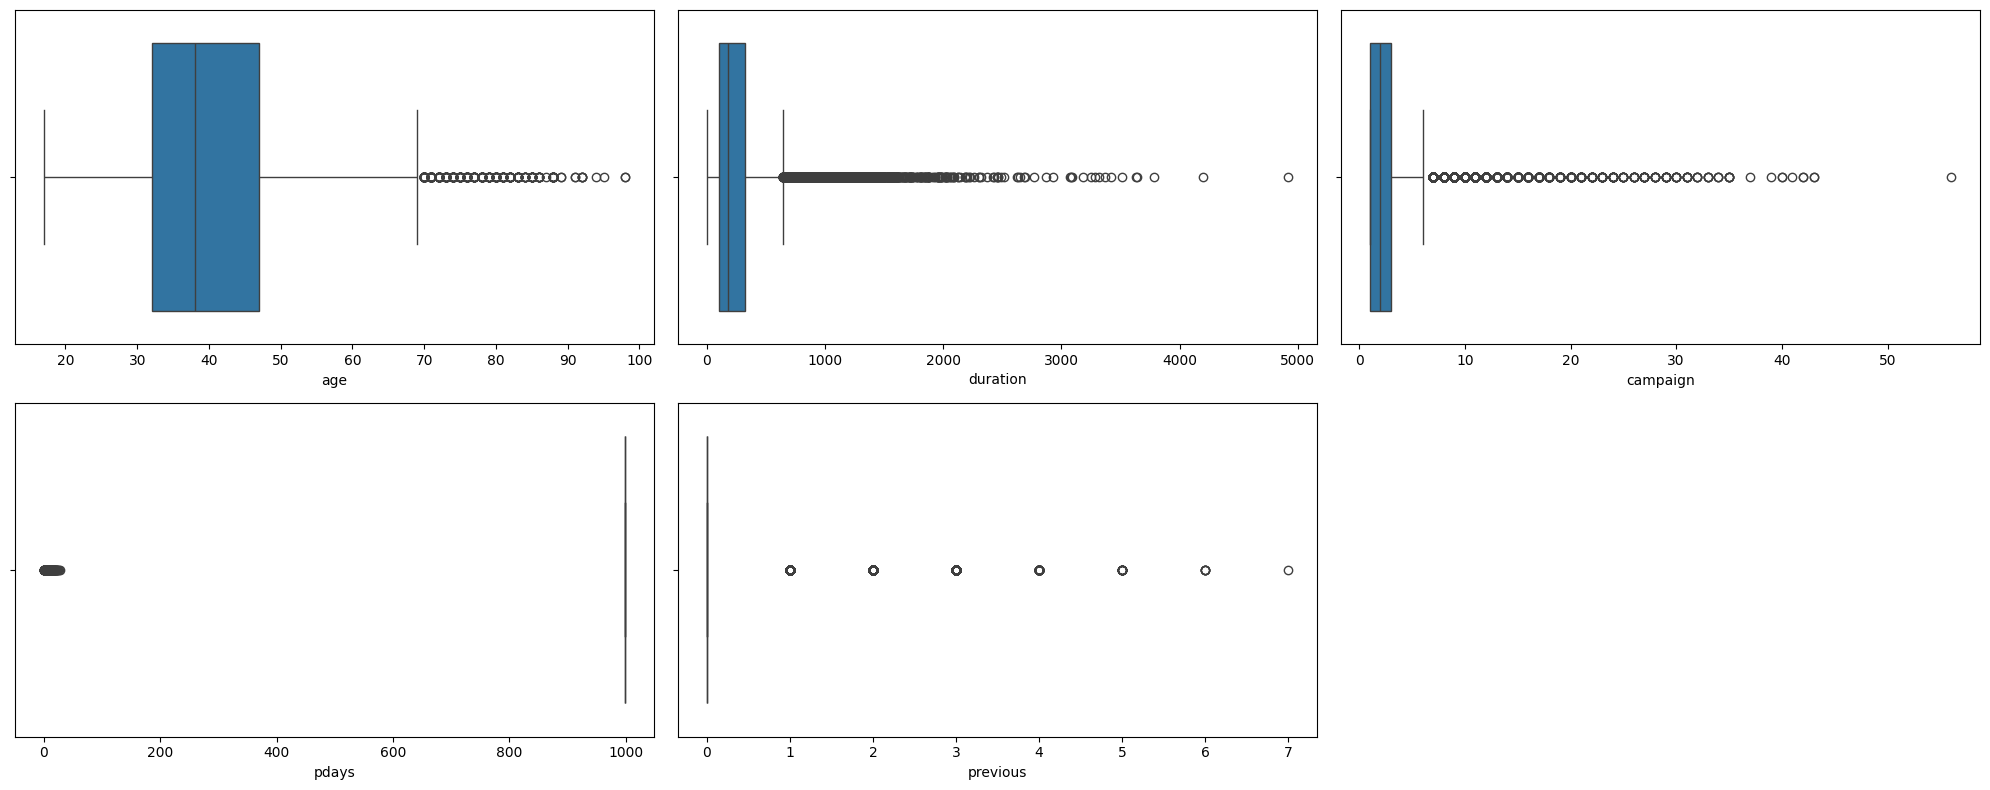

In [91]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
sns.boxplot(data=df, x='age',ax=ax1)
sns.boxplot(data=df, x='duration',ax=ax2)
sns.boxplot(data=df, x='campaign',ax=ax3)
sns.boxplot(data=df, x='pdays',ax=ax4)
sns.boxplot(data=df, x='previous',ax=ax5)
fig.delaxes(ax6)
plt.tight_layout()
plt.show()

`We will NOT remove outliers because:`
1. Outliers may represent legitimate extreme cases (e.g., very long call duration)
2. They may contain valuable predictive information
3. We'll use robust scaling methods that handle outliers well
4. Tree-based models are robust to outliers

### 3.1.4 Target Imbalance Detection

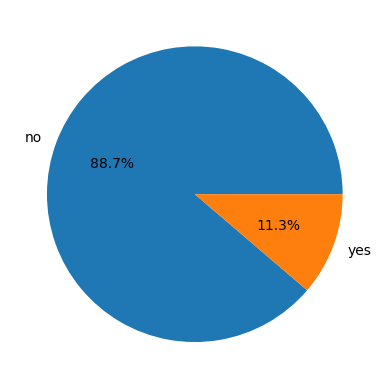

In [92]:
plt.pie(df['y'].value_counts(), labels=['no', 'yes'], autopct='%1.1f%%')
plt.show()

`Target Conclusion:` Target has class imbalance 11.3% yes and 88.7% no

## 3.2 Explanatory Data Analysis

Personal data except credit default

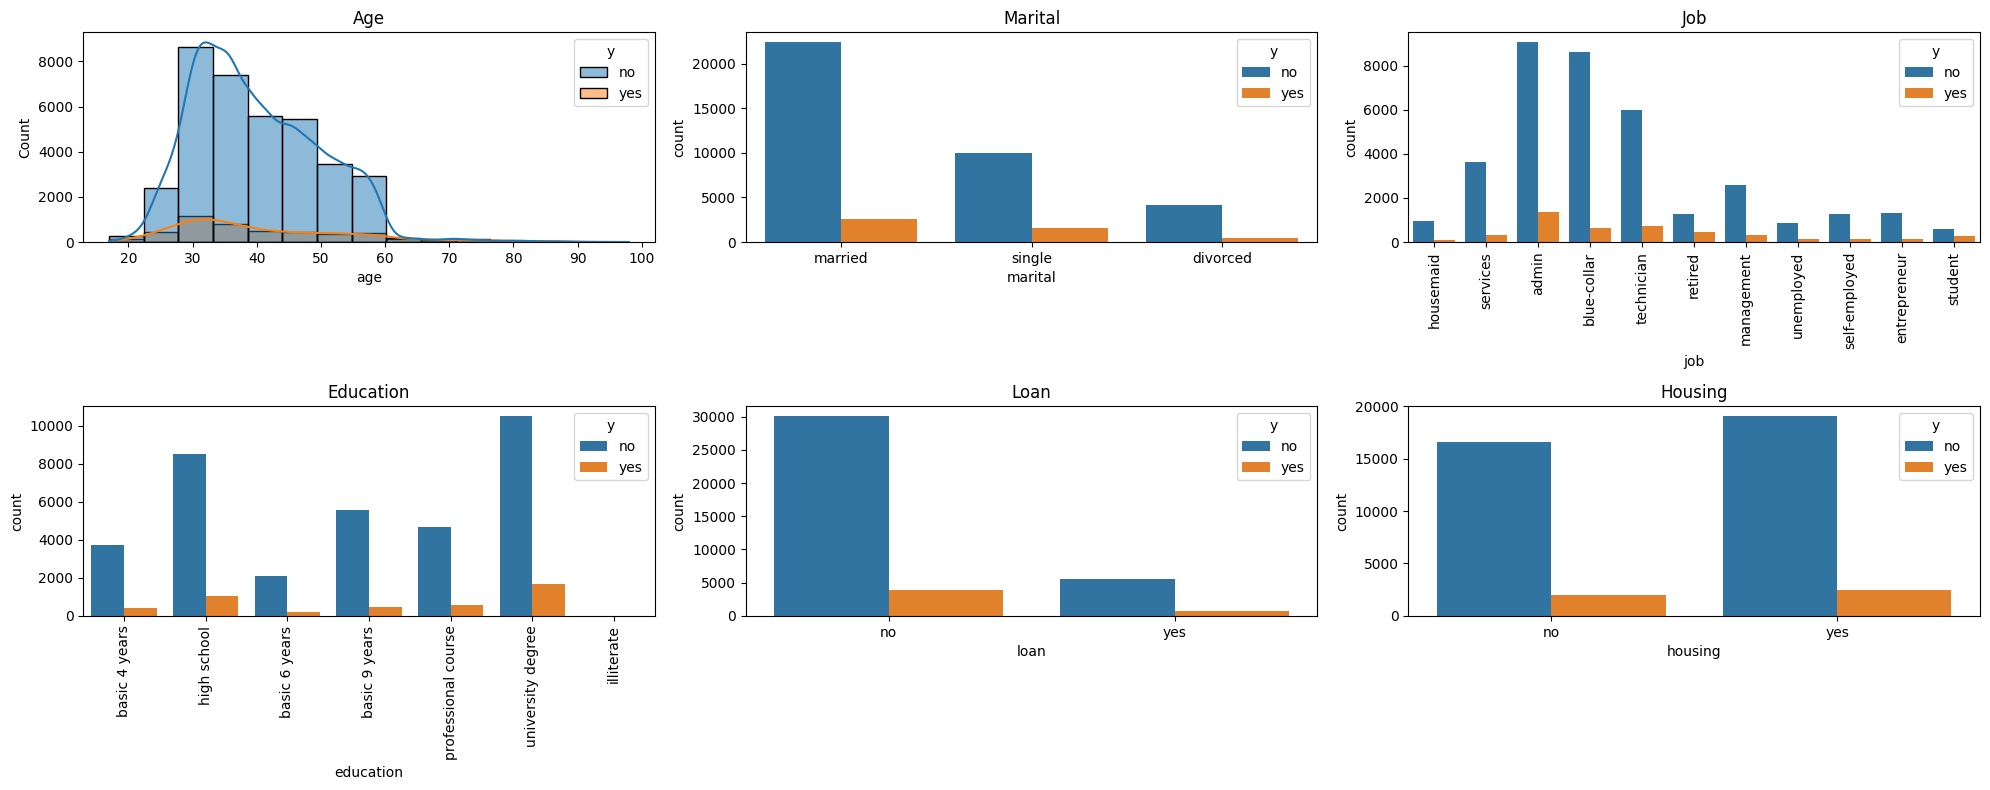

In [93]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
sns.histplot(data=df, x='age',hue='y',kde=True,bins=15, ax=ax1)
sns.countplot(data=df, x='marital',hue='y', ax=ax2)
sns.countplot(data=df, x='job',hue='y',ax=ax3)
sns.countplot(data=df, x='education',hue='y',ax=ax4)
sns.countplot(data=df, x='loan',hue='y',ax=ax5)
sns.countplot(data=df, x='housing',hue='y',ax=ax6)
ax1.set_title('Age')
ax2.set_title('Marital')
ax3.set_title('Job')
ax4.set_title('Education')
ax5.set_title('Loan')
ax6.set_title('Housing')
ax3.tick_params(axis='x', labelrotation=90)
ax4.tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

Default

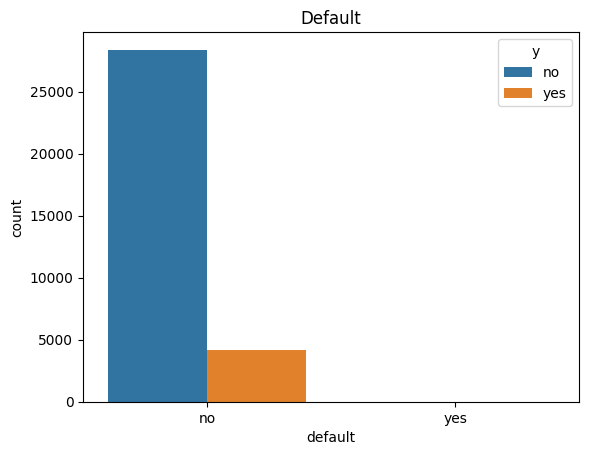

In [94]:
sns.countplot(data=df, x='default',hue='y')
plt.title('Default')
plt.show()

Related to contact last campaign

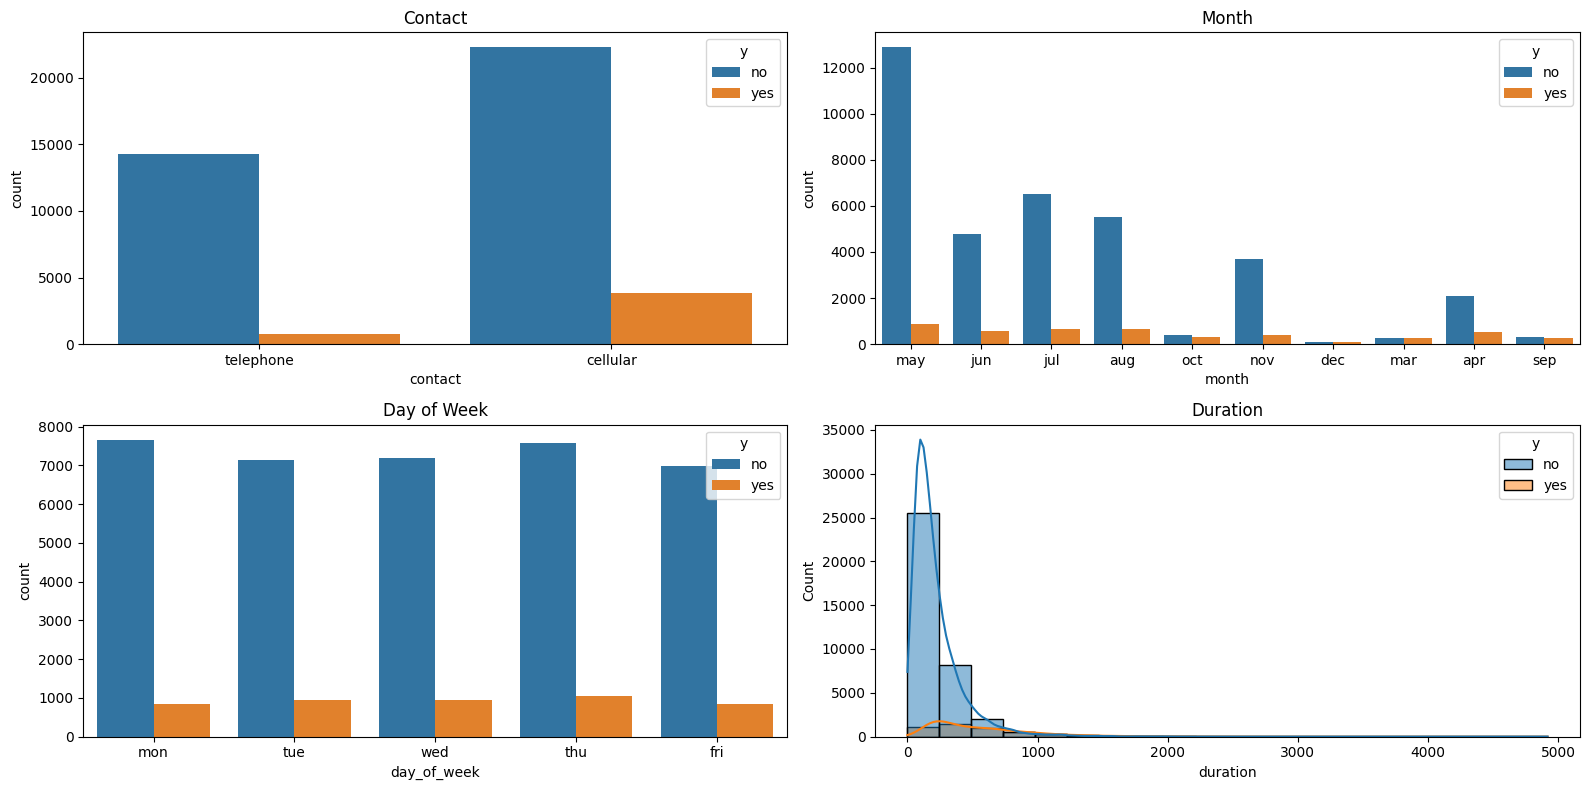

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
ax1, ax2, ax3, ax4 = axes.flatten()
sns.countplot(data=df, x='contact',hue='y',ax=ax1)
ax1.set_title('Contact')
sns.countplot(data=df, x='month',hue='y',ax=ax2)
ax2.set_title('Month')
sns.countplot(data=df, x='day_of_week',hue='y',ax=ax3)
ax3.set_title('Day of Week')
sns.histplot(data=df, x='duration',hue='y',kde=True,bins=20,ax=ax4)
ax4.set_title('Duration')
plt.tight_layout()
plt.show()

Other

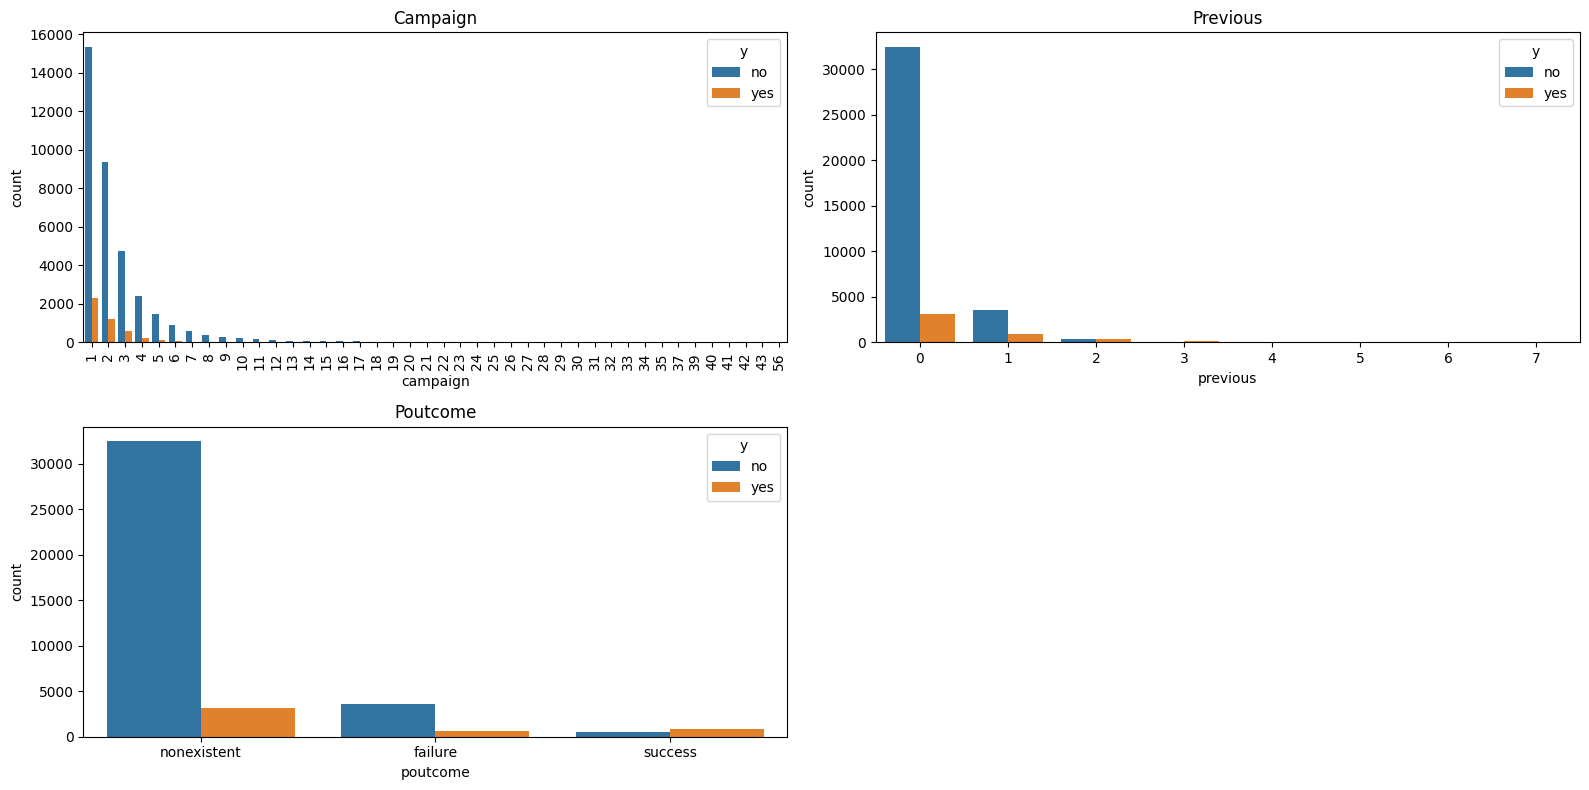

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
ax1, ax2, ax3, ax4 = axes.flatten()
sns.countplot(data=df, x='campaign',hue='y',ax=ax1)
ax1.title.set_text('Campaign')
ax1.tick_params(axis='x', labelrotation=90)
sns.countplot(data=df, x='previous',hue='y',ax=ax2)
ax2.title.set_text('Previous')
sns.countplot(data=df, x='poutcome',hue='y',ax=ax3)
ax3.title.set_text('Poutcome')
fig.delaxes(ax4)
plt.tight_layout()
plt.show()

Pdays

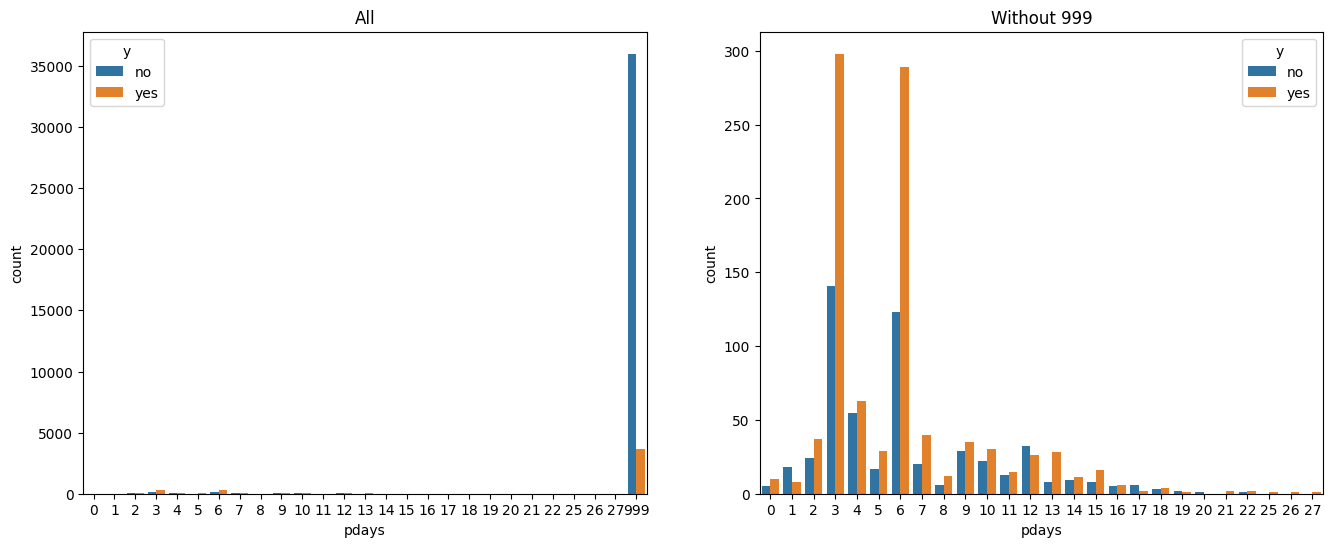

In [97]:
fig,axes = plt.subplots(1,2,figsize=(16,6))
ax1,ax2 = axes
df_filtered = df[df['pdays'] != 999]
sns.countplot(data=df_filtered, x='pdays', hue='y',ax=ax2)
sns.countplot(data=df, x='pdays', hue='y',ax=ax1)
ax1.title.set_text('All')
ax2.title.set_text('Without 999')
plt.show()

without 999

Socio-economic factors

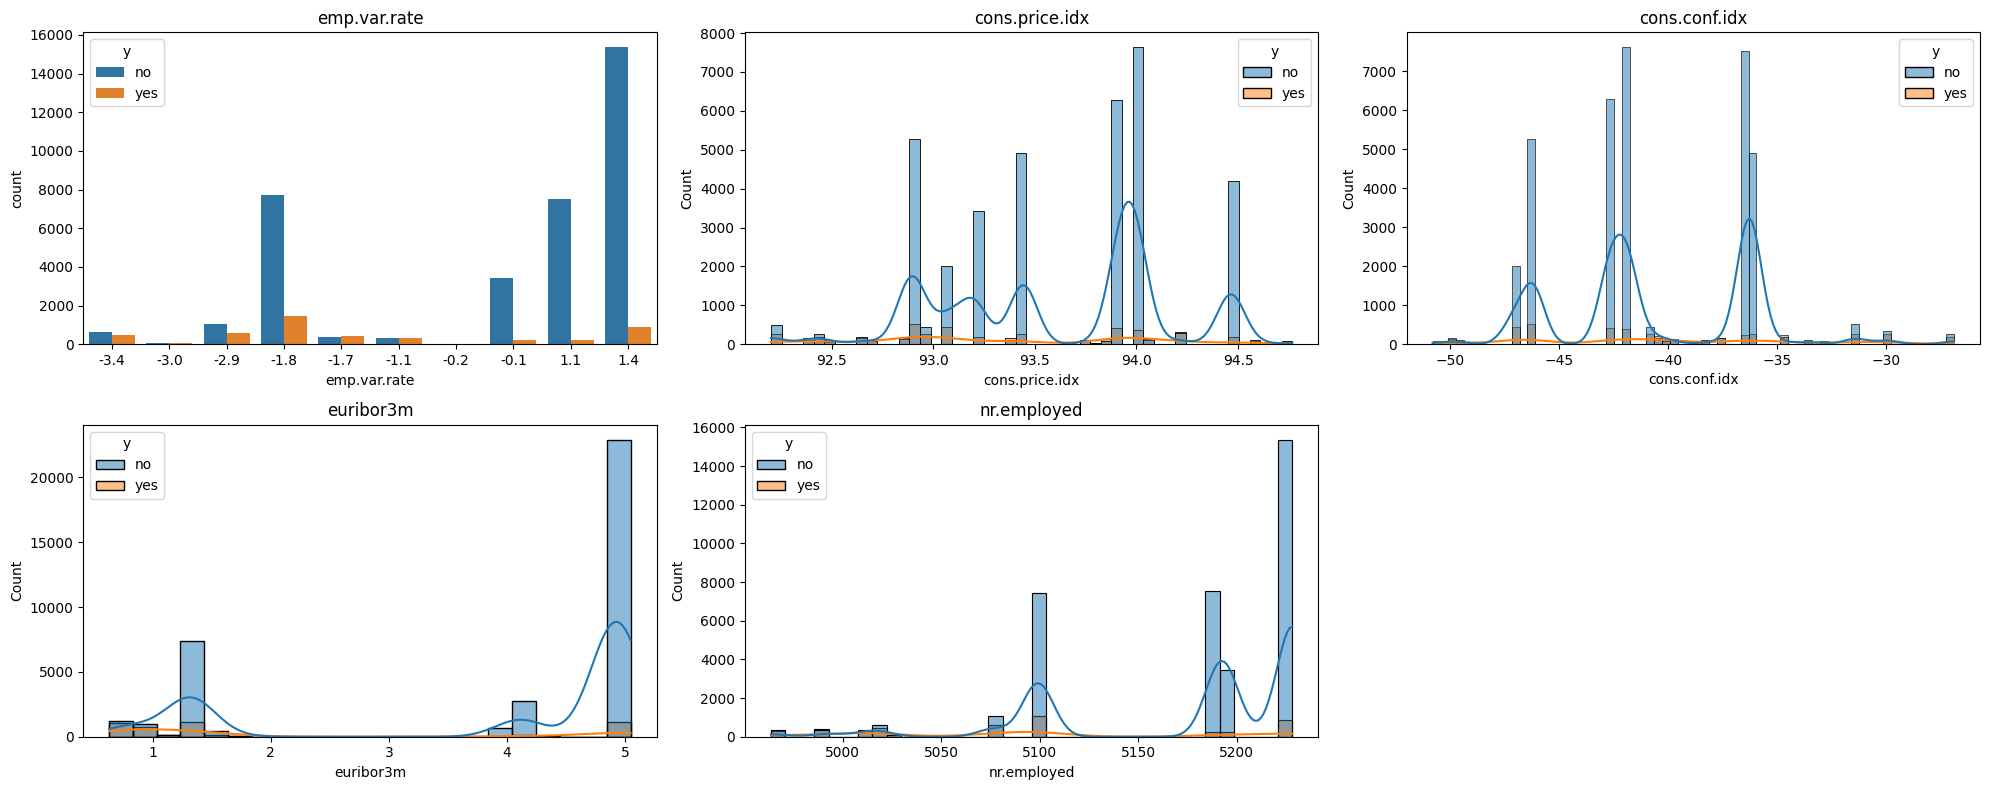

In [98]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
sns.countplot(data=df, x='emp.var.rate', hue='y', ax=ax1)
sns.histplot(data=df, x='cons.price.idx', hue='y', kde=True, ax=ax2)
sns.histplot(data=df, x='cons.conf.idx',  hue='y', kde=True, ax=ax3)
sns.histplot(data=df, x='euribor3m',      hue='y', kde=True, ax=ax4)
sns.histplot(data=df, x='nr.employed',    hue='y', kde=True, ax=ax5)
ax1.set_title('emp.var.rate')
ax2.set_title('cons.price.idx')
ax3.set_title('cons.conf.idx')
ax4.set_title('euribor3m')
ax5.set_title('nr.employed')
fig.delaxes(ax6)
plt.tight_layout()
plt.show()

## 3.3 Inferential Stats

numerical value analysis

In [99]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
for feature in numerical_features:
    print(f"Feature: {feature}")
    print('='*60)
    subscribed_yes = df[df['y'] == 'yes'][feature].dropna()
    subscribed_no = df[df['y'] == 'no'][feature].dropna()

    statistic, p_value = mannwhitneyu(subscribed_yes, subscribed_no, alternative='two-sided')
    print(f"\nMann-Whitney U Test:")
    print(f"  Statistic: {statistic:.2f}")
    print(f"  P-value: {p_value:.6f}")

    if p_value < 0.05:
        print(f"SIGNIFICANT: {feature} shows significant difference between subscribers and non-subscribers")
    else:
        print(f"NOT SIGNIFICANT: {feature} does not show significant difference")

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

Feature: age

Mann-Whitney U Test:
  Statistic: 82955833.50
  P-value: 0.016081
SIGNIFICANT: age shows significant difference between subscribers and non-subscribers
Feature: duration

Mann-Whitney U Test:
  Statistic: 138794276.50
  P-value: 0.000000
SIGNIFICANT: duration shows significant difference between subscribers and non-subscribers
Feature: campaign

Mann-Whitney U Test:
  Statistic: 75428808.50
  P-value: 0.000000
SIGNIFICANT: campaign shows significant difference between subscribers and non-subscribers
Feature: pdays

Mann-Whitney U Test:
  Statistic: 68384810.00
  P-value: 0.000000
SIGNIFICANT: pdays shows significant difference between subscribers and non-subscribers
Feature: previous

Mann-Whitney U Test:
  Statistic: 103324818.50
  P-value: 0.000000
SIGNIFICANT: previous shows significant difference between subscribers and non-subscribers
Feature: emp.var.rate

Mann-Whitney U Test:
  Statistic: 48033797.00
  P-value: 0.000000
SIGNIFICANT: emp.var.rate shows significant d

categorical analysis using chi-squared

In [100]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

for feature in categorical_features:
    print(f"\n{'='*60}")
    print(f"Feature: {feature}")
    print('='*60)

    # Crosstab
    ct = pd.crosstab(df[feature], df['y'], normalize='index') * 100
    print(f"\nSubscription rate by {feature}:")
    print(ct)

    # Chi-square test
    contingency_table = pd.crosstab(df[feature], df['y'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print(f"\nChi-Square Test:")
    print(f"  Chi-square statistic: {chi2:.2f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Degrees of freedom: {dof}")

    if p_value < 0.05:
        print(f"SIGNIFICANT: {feature} is significantly associated with subscription")
    else:
        print(f"NOT SIGNIFICANT: {feature} is not significantly associated")


Feature: job

Subscription rate by job:
y                     no        yes
job                                
admin          87.027442  12.972558
blue-collar    93.105684   6.894316
entrepreneur   91.483516   8.516484
housemaid      90.000000  10.000000
management     88.782490  11.217510
retired        74.767442  25.232558
self-employed  89.514426  10.485574
services       91.861930   8.138070
student        68.571429  31.428571
technician     89.173958  10.826042
unemployed     85.798817  14.201183

Chi-Square Test:
  Chi-square statistic: 961.21
  P-value: 0.000000
  Degrees of freedom: 10
SIGNIFICANT: job is significantly associated with subscription

Feature: marital

Subscription rate by marital:
y                no        yes
marital                       
divorced  89.679098  10.320902
married   89.842747  10.157253
single    85.995851  14.004149

Chi-Square Test:
  Chi-square statistic: 121.61
  P-value: 0.000000
  Degrees of freedom: 2
SIGNIFICANT: marital is significantly

numerical corelation

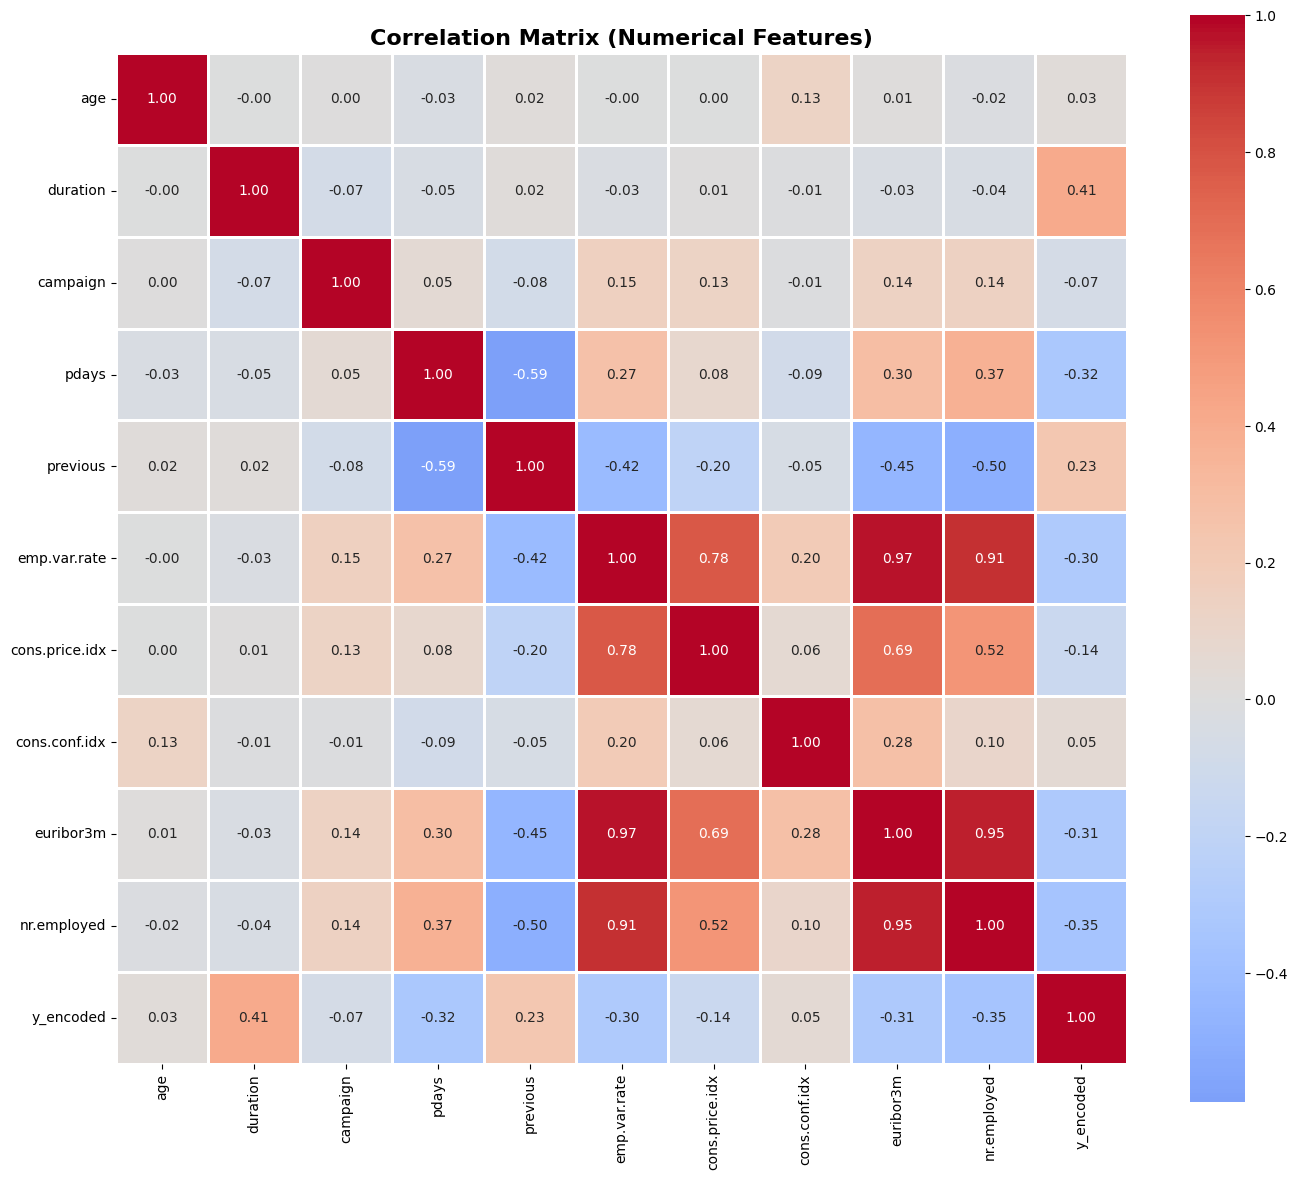

In [101]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
df_corr = df.copy()
df_corr['y_encoded'] = df_corr['y'].map({'no': 0, 'yes': 1})

# Calculate correlation matrix
corr_matrix = df_corr[numerical_features + ['y_encoded']].corr()

# Visualize correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix (Numerical Features)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. data preprocessing

make a copy of original df

In [102]:
df_processed = df.copy()

## 4.1 Handling missing value and dropping socio-economic features

Handling missing value

In [103]:
df_processed.drop('default', axis=1, inplace=True)

In [104]:
df_processed.dropna(subset=['housing', 'loan'], inplace=True)

In [105]:
df_processed.drop(['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1, inplace=True)

In [106]:
df_processed['was_contacted_before'] = df_processed['pdays'].apply(lambda x: 'no' if x == 999 else 'yes')
df_processed.drop('pdays', axis=1, inplace=True)

In [107]:
df_processed.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y,was_contacted_before
0,56,housemaid,married,basic 4 years,no,no,telephone,may,mon,261,1,0,nonexistent,no,no
1,57,services,married,high school,no,no,telephone,may,mon,149,1,0,nonexistent,no,no
2,37,services,married,high school,yes,no,telephone,may,mon,226,1,0,nonexistent,no,no
3,40,admin,married,basic 6 years,no,no,telephone,may,mon,151,1,0,nonexistent,no,no
4,56,services,married,high school,no,yes,telephone,may,mon,307,1,0,nonexistent,no,no


# 5. Define X and y (target and features)

In [108]:
y = df_processed['y'].map({'no': 0, 'yes': 1})
X = df_processed.drop('y', axis=1)

split cat and num

In [109]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

# 6. Train-test split

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. Feature engineering

In [111]:
numerical_pipeline = Pipeline([
    ('scaler', RobustScaler())  # Robust to outliers
])

# Categorical pipeline: Impute + Encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# 8. Model Benchmarking

In [112]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

results = []

for model_name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f2 = (5 * precision * recall) / (4 * precision + recall) if (precision + recall) > 0 else 0
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_curve, precision_curve)
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'F2-Score': f2,
        'PR-AUC': pr_auc,
        'ROC-AUC': roc_auc
    })

In [113]:
benchmark_df = pd.DataFrame(results)
benchmark_df = benchmark_df.sort_values('F2-Score', ascending=False)

In [114]:
benchmark_df

,Model,Accuracy,Precision,Recall,F1-Score,F2-Score,PR-AUC,ROC-AUC
7,LightGBM,0.912438,0.641958,0.506064,0.565968,0.528437,0.601872,0.735087
8,XGBoost,0.906343,0.609687,0.471885,0.532007,0.494226,0.570575,0.716736
6,CatBoost,0.909826,0.640432,0.457552,0.533762,0.485267,0.579589,0.712444
4,Gradient Boosting,0.909950,0.648780,0.439912,0.524310,0.470186,0.575938,0.704815
2,Decision Tree,0.866542,0.416499,0.456450,0.435560,0.447858,0.467134,0.687569
3,Random Forest,0.906219,0.626446,0.417861,0.501323,0.447673,0.554990,0.693089
0,Logistic Regression,0.906219,0.650888,0.363837,0.466761,0.399033,0.543245,0.669511
1,KNN,0.896642,0.565517,0.361632,0.441157,0.389734,0.499582,0.663151
5,AdaBoost,0.902736,0.631579,0.330761,0.434153,0.365586,0.518919,0.653113


Visualizing benchmark df

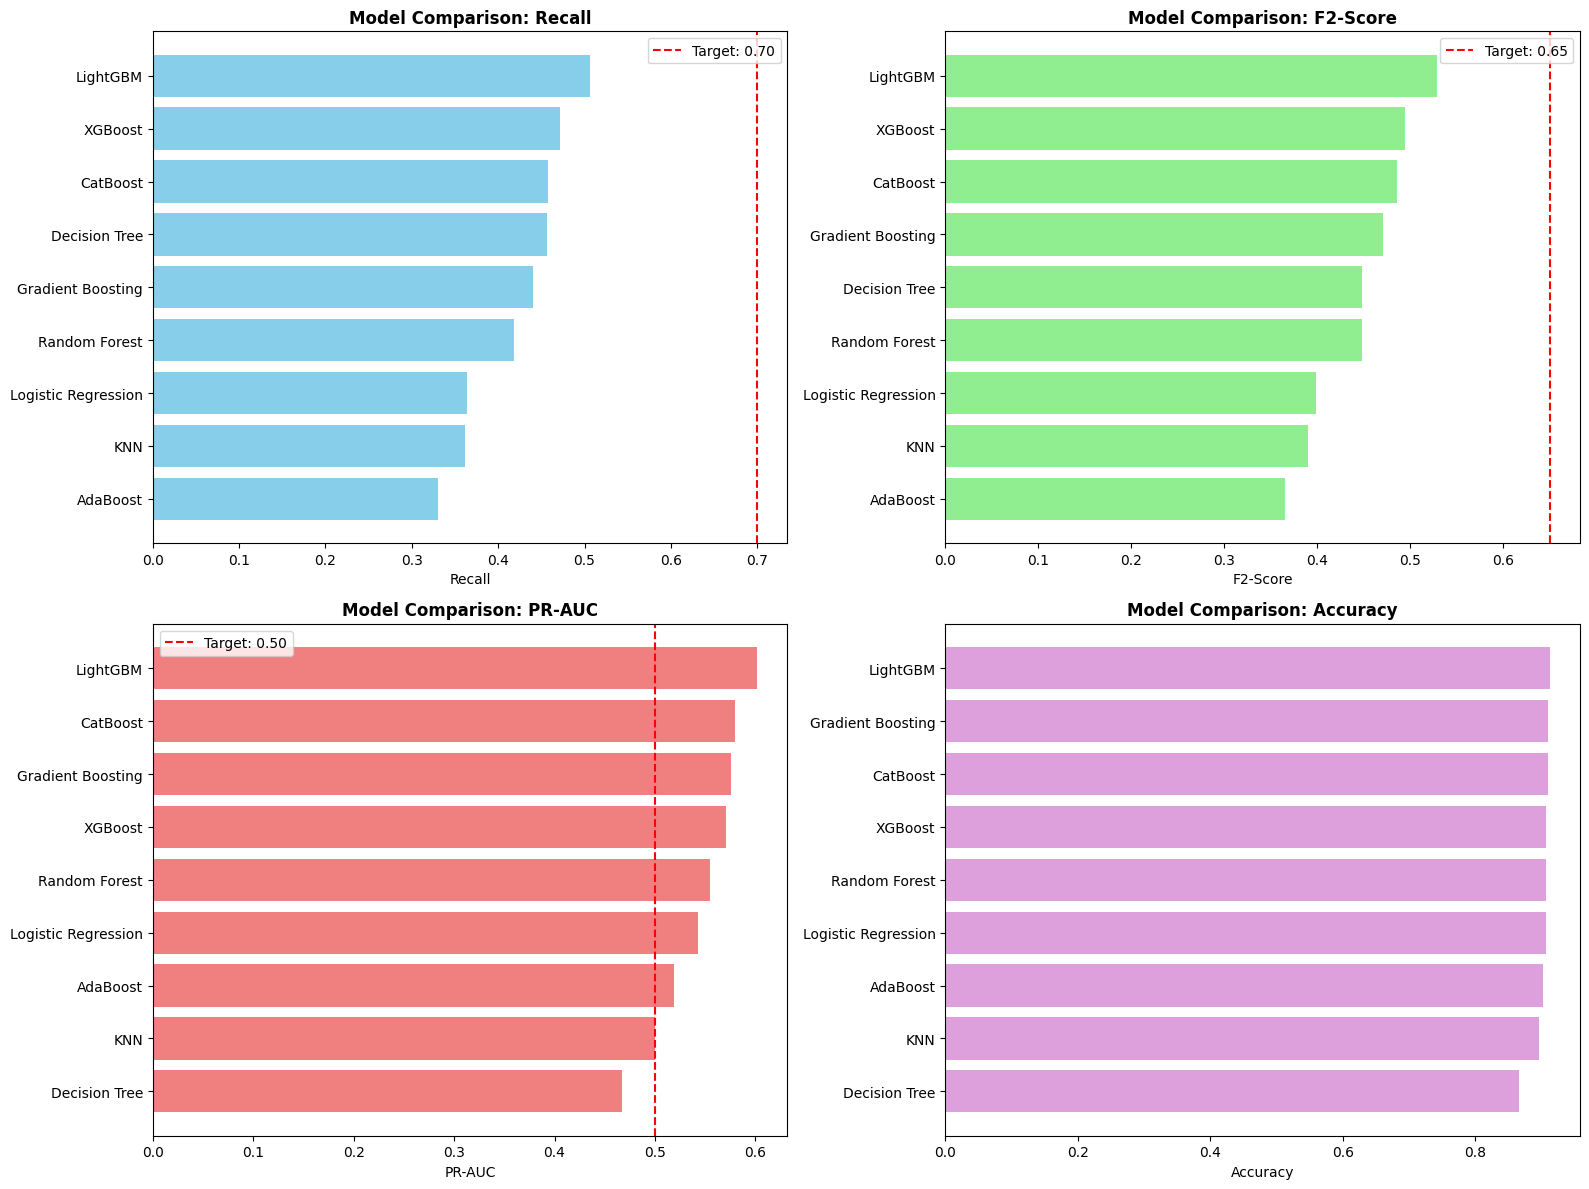

In [115]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot Recall
benchmark_df_sorted = benchmark_df.sort_values('Recall')
axes[0, 0].barh(benchmark_df_sorted['Model'], benchmark_df_sorted['Recall'], color='skyblue')
axes[0, 0].set_xlabel('Recall')
axes[0, 0].set_title('Model Comparison: Recall', fontweight='bold')
axes[0, 0].axvline(x=0.7, color='r', linestyle='--', label='Target: 0.70')
axes[0, 0].legend()

# Plot F2-Score
benchmark_df_sorted = benchmark_df.sort_values('F2-Score')
axes[0, 1].barh(benchmark_df_sorted['Model'], benchmark_df_sorted['F2-Score'], color='lightgreen')
axes[0, 1].set_xlabel('F2-Score')
axes[0, 1].set_title('Model Comparison: F2-Score', fontweight='bold')
axes[0, 1].axvline(x=0.65, color='r', linestyle='--', label='Target: 0.65')
axes[0, 1].legend()

# Plot PR-AUC
benchmark_df_sorted = benchmark_df.sort_values('PR-AUC')
axes[1, 0].barh(benchmark_df_sorted['Model'], benchmark_df_sorted['PR-AUC'], color='lightcoral')
axes[1, 0].set_xlabel('PR-AUC')
axes[1, 0].set_title('Model Comparison: PR-AUC', fontweight='bold')
axes[1, 0].axvline(x=0.5, color='r', linestyle='--', label='Target: 0.50')
axes[1, 0].legend()

# Plot Accuracy
benchmark_df_sorted = benchmark_df.sort_values('Accuracy')
axes[1, 1].barh(benchmark_df_sorted['Model'], benchmark_df_sorted['Accuracy'], color='plum')
axes[1, 1].set_xlabel('Accuracy')
axes[1, 1].set_title('Model Comparison: Accuracy', fontweight='bold')

plt.tight_layout()
plt.show()

LightGBM has the highest amongs multiple criteria

# 9. Class Imbalance -- Resampling Methods

In [116]:
base_model = LGBMClassifier(random_state=42, verbose=-1)

resampling_methods = {
    'No Resampling (Baseline)': None,
    'Random Over-Sampling': RandomOverSampler(random_state=42),
    'Random Under-Sampling': RandomUnderSampler(random_state=42),
    'Near Miss': NearMiss(version=1),
    'SMOTE': SMOTE(random_state=42),
    'SMOTEENN (Hybrid)': SMOTEENN(random_state=42)
}

resampling_results = []

for method_name, sampler in resampling_methods.items():
    print(f"Testing {method_name}...")

    if sampler is None:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', base_model)
        ])
        pipeline.fit(X_train, y_train)
    else:
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('sampler', sampler),
            ('classifier', base_model)
        ])
        pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f2 = (5 * precision * recall) / (4 * precision + recall) if (precision + recall) > 0 else 0

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_curve, precision_curve)

    resampling_results.append({
        'Model': method_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'F2-Score': f2,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    })

    print(f"  {method_name} - Recall: {recall:.4f}, F2-Score: {f2:.4f}")

Testing No Resampling (Baseline)...
  No Resampling (Baseline) - Recall: 0.5061, F2-Score: 0.5284
Testing Random Over-Sampling...
  Random Over-Sampling - Recall: 0.8666, F2-Score: 0.7175
Testing Random Under-Sampling...
  Random Under-Sampling - Recall: 0.8721, F2-Score: 0.7098
Testing Near Miss...
  Near Miss - Recall: 0.8302, F2-Score: 0.5624
Testing SMOTE...
  SMOTE - Recall: 0.5821, F2-Score: 0.5772
Testing SMOTEENN (Hybrid)...
  SMOTEENN (Hybrid) - Recall: 0.8060, F2-Score: 0.7027


In [118]:
resampling_df = pd.DataFrame(resampling_results)
resampling_df = resampling_df.sort_values('F2-Score', ascending=False)
print(f'Best resampling method: {resampling_df.iloc[0]['Model']}')

Best resampling method: Random Over-Sampling


# 10. Balanced model

In [119]:
balanced_model = LGBMClassifier(objective='binary', random_state=42, verbose=-1, is_unbalance=True)
class_weight_results = []
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', balanced_model)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f2 = (5 * precision * recall) / (4 * precision + recall) if (precision + recall) > 0 else 0

precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Score: {f2:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

class_weight_results.append({
    'Model': 'Balanced Model',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'F2-Score': f2,
    'ROC-AUC': roc_auc,
    'PR-AUC': pr_auc
})


Accuracy: 0.8525
Precision: 0.4250
Recall: 0.8710
F1-Score: 0.5712
F2-Score: 0.7199
ROC-AUC: 0.9279
PR-AUC: 0.6102


# 11. Hyperparameter Tuning

In [120]:
lightgbm_hyperparam = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [30, 60],
    'classifier__is_unbalance': [True, False]
    }
tuned_results = []

tuning_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', base_model)
])

f2_scorer = make_scorer(fbeta_score, beta=2)
grid_search = GridSearchCV(
    tuning_pipeline,
    lightgbm_hyperparam,
    scoring=f2_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F2-score: {grid_search.best_score_:.4f}")

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f2 = (5 * precision * recall) / (4 * precision + recall) if (precision + recall) > 0 else 0

precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Score: {f2:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

tuned_results.append({
    'Model': 'Tuned Model',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'F2-Score': f2,
    'ROC-AUC': roc_auc,
    'PR-AUC': pr_auc
})

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'classifier__is_unbalance': True, 'classifier__learning_rate': 0.05, 'classifier__n_estimators': 100, 'classifier__num_leaves': 30}
Best cross-validation F2-score: 0.7222
Accuracy: 0.8461
Precision: 0.4146
Recall: 0.8831
F1-Score: 0.5643
F2-Score: 0.7203
ROC-AUC: 0.9283
PR-AUC: 0.6134


# 12. Model Evaluation

In [121]:
df_benchmark = pd.DataFrame(results)
df_resampled = pd.DataFrame(resampling_results)
df_balanced  = pd.DataFrame(class_weight_results)
df_tuned     = pd.DataFrame(tuned_results)

# 2. Add a 'Stage' column to identify them
df_benchmark['Stage'] = 'Benchmark'
df_resampled['Stage'] = 'Resampling'
df_balanced['Stage']  = 'Balanced'
df_tuned['Stage']     = 'Tuned'

# 3. Combine everything into one big DataFrame
df_all = pd.concat([df_benchmark, df_resampled, df_balanced, df_tuned], ignore_index=True)

In [122]:
df_all

,Model,Accuracy,Precision,Recall,F1-Score,F2-Score,PR-AUC,ROC-AUC,Stage
0,Logistic Regression,0.906219,0.650888,0.363837,0.466761,0.399033,0.543245,0.669511,Benchmark
1,KNN,0.896642,0.565517,0.361632,0.441157,0.389734,0.499582,0.663151,Benchmark
2,Decision Tree,0.866542,0.416499,0.456450,0.435560,0.447858,0.467134,0.687569,Benchmark
3,Random Forest,0.906219,0.626446,0.417861,0.501323,0.447673,0.554990,0.693089,Benchmark
4,Gradient Boosting,0.909950,0.648780,0.439912,0.524310,0.470186,0.575938,0.704815,Benchmark
5,AdaBoost,0.902736,0.631579,0.330761,0.434153,0.365586,0.518919,0.653113,Benchmark
6,CatBoost,0.909826,0.640432,0.457552,0.533762,0.485267,0.579589,0.712444,Benchmark
7,LightGBM,0.912438,0.641958,0.506064,0.565968,0.528437,0.601872,0.735087,Benchmark
8,XGBoost,0.906343,0.609687,0.471885,0.532007,0.494226,0.570575,0.716736,Benchmark
9,No Resampling (Baseline),0.912438,0.641958,0.506064,0.565968,0.528437,0.613003,0.929461,Resampling


In [125]:
best_models = df_all.loc[df_all.groupby("Stage")["F2-Score"].idxmax()]
stage_order = ['Benchmark', 'Resampling', 'Balanced', 'Tuned']
best_models['Stage'] = pd.Categorical(best_models['Stage'], categories=stage_order, ordered=True)
best_models = best_models.sort_values('Stage')
best_models.style.highlight_max(color='green', axis=0)


,Model,Accuracy,Precision,Recall,F1-Score,F2-Score,PR-AUC,ROC-AUC,Stage
7,LightGBM,0.912438,0.641958,0.506064,0.565968,0.528437,0.601872,0.735087,Benchmark
10,Random Over-Sampling,0.852736,0.425095,0.866593,0.570392,0.717546,0.598951,0.925408,Resampling
15,Balanced Model,0.852488,0.424960,0.871003,0.571222,0.719883,0.610163,0.927920,Balanced
16,Tuned Model,0.846144,0.414596,0.883131,0.564283,0.720324,0.613405,0.928275,Tuned


# 13. Cost Benefit Analysis and Shap interpretable model

✓ SHAP values calculated
✓ SHAP summary plot saved as 'shap_summary.png'


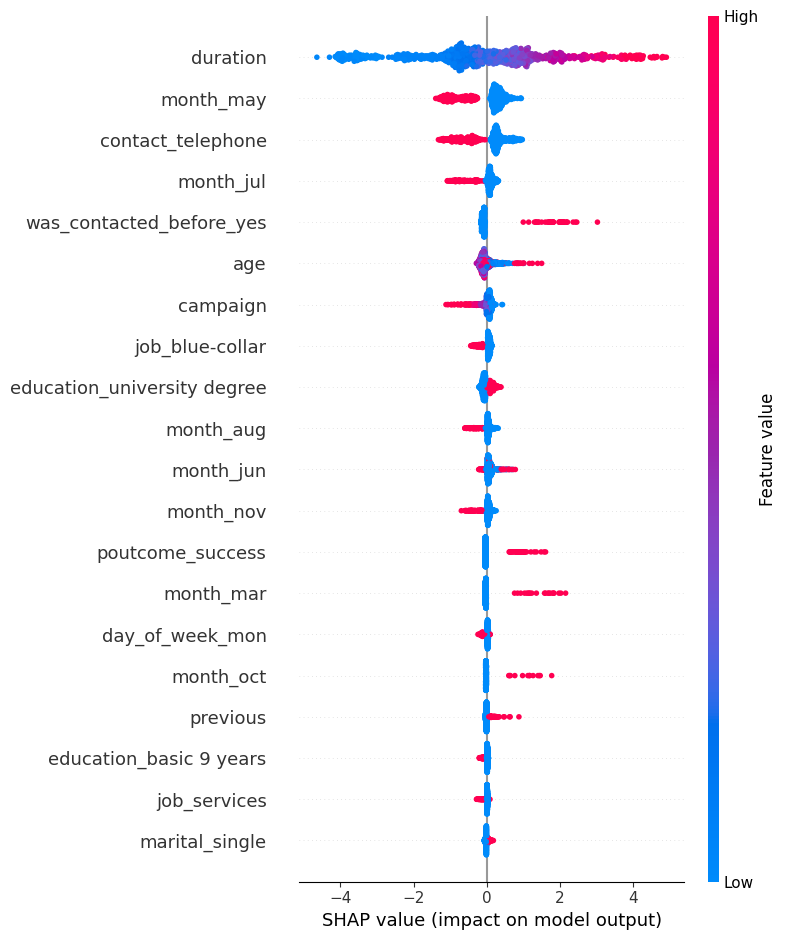

In [ ]:
X_train_preprocessed = best_model.named_steps['preprocessor'].transform(X_train)

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_train_preprocessed[:1000])  # Use subset for speed

# Get feature names after preprocessing
feature_names_encoded = (
    numerical_features + 
    list(best_model.named_steps['preprocessor']
         .named_transformers_['cat']
         .named_steps['encoder']
         .get_feature_names_out(categorical_features))
)

# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_preprocessed[:1000], 
                 feature_names=feature_names_encoded, show=False)
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
print("✓ SHAP summary plot saved as 'shap_summary.png'")
plt.show()

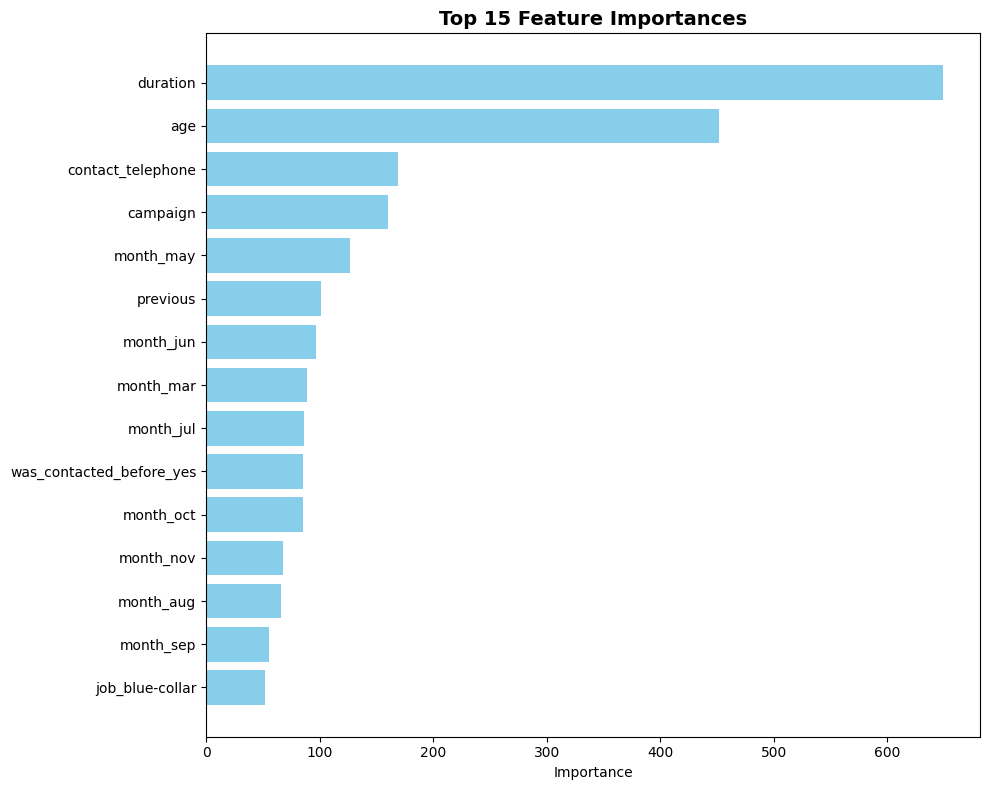

In [131]:
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_importance = best_model.named_steps['classifier'].feature_importances_

    # Create dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names_encoded,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False).head(15)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# 14. Conclusion and Recommendation

`Conclusion`

1. MODEL PERFORMANCE:
   - Achieved Recall: TBA (Target: ≥0.70) {}
   - Achieved F2-Score: TBA (Target: ≥0.65) {}
   - Achieved PR-AUC: TBA (Target: ≥0.50) {}

2. KEY FINDINGS:
   - Successfully built a predictive model for term deposit subscriptions
   - Addressed class imbalance through resampling and class weighting
   - Identified most influential features for subscription prediction
   - Model provides actionable insights for marketing optimization

3. BUSINESS IMPACT:
   - Estimated net benefit: ${:,.2f} compared to baseline approach
   - Enables targeted marketing campaigns with higher efficiency
   - Reduces unnecessary customer contacts improving satisfaction
   - Provides data-driven prioritization for call center operations

`Recommendation`

A. DATA RECOMMENDATIONS:
   1. Collect more granular customer demographic data
   2. Include customer lifetime value information
   3. Track customer engagement metrics across channels
   4. Incorporate seasonal and temporal patterns more explicitly
   5. Gather post-campaign feedback for continuous improvement

B. MODEL RECOMMENDATIONS:
   1. Implement regular model retraining (quarterly recommended)
   2. Monitor for model drift and performance degradation
   3. Experiment with ensemble methods combining multiple models
   4. Consider deep learning approaches if dataset grows significantly
   5. Implement A/B testing framework for model validation

C. BUSINESS RECOMMENDATIONS:

   For Marketing Team:
   - Use model predictions to prioritize high-probability clients (score > 0.7)
   - Segment clients into tiers: High (>0.7), Medium (0.4-0.7), Low (<0.4)
   - Allocate more resources to high-probability segments
   - Develop targeted messaging strategies for each segment

   For Call Center Operations:
   - Optimize call scheduling based on predicted conversion likelihood
   - Train agents on key features that influence subscriptions
   - Implement dynamic contact frequency based on prediction scores
   - Track and analyze reasons for false negatives to improve model

   For Model Maintenance:
   - Retrain model every 3-6 months with new campaign data
   - Monitor prediction accuracy on new campaigns
   - Update feature engineering as new data sources become available
   - Maintain documentation of model versions and performance metrics

   For Model Deployment:
   - Deploy model as API service for real-time predictions
   - Integrate with CRM system for seamless workflow
   - Implement feedback loop to capture actual outcomes
   - Set up monitoring dashboard for model performance tracking

   When to Use Model:
   - At campaign planning stage to size target audience
   - Before initiating client contacts to prioritize call lists
   - For budget allocation across different client segments
   - To evaluate ROI of different campaign strategies

D. ETHICAL CONSIDERATIONS:
   - Ensure fair treatment across demographic groups
   - Regularly audit for bias in predictions
   - Maintain transparency in decision-making process
   - Respect customer preferences and privacy
   - Comply with data protection regulations

E. SUCCESS METRICS MONITORING:
   - Track actual subscription rate vs predicted rate
   - Monitor campaign ROI improvement over time
   - Measure customer satisfaction scores
   - Analyze cost per acquisition trends
   - Evaluate false negative rate impact on revenue

# 15. Pickle Deployment

In [132]:
model_filename = 'bank_marketing_model.sav'
joblib.dump(best_model, model_filename)

['bank_marketing_model.sav']